<a href="https://colab.research.google.com/github/heokwon/Training-for-Competiton/blob/main/Inference_efiicient_encoder_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In particular, we have made inferences with reference to [HuBMAP fast.ai starter (EfficientNet) by wangkui](https://www.kaggle.com/code/befunny/hubmap-fast-ai-starter-efficientnet)

## Reference

- [HuBMAP fast.ai starter (EfficientNet) by wangkui](https://www.kaggle.com/code/befunny/hubmap-fast-ai-starter-efficientnet)
- [Converting to 256x256 by The Devastator](https://www.kaggle.com/code/thedevastator/converting-to-256x256)
- [[Training] - FastAI Baseline by The Devastator](https://www.kaggle.com/code/thedevastator/training-fastai-baseline)
- [[Inference] - FastAI Baseline by The Devastator](https://www.kaggle.com/code/thedevastator/inference-fastai-baseline)

In [ ]:
"""
Lovasz-Softmax and Jaccard hinge loss in PyTorch
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / union
        ious.append(iou)
    iou = f_mean(ious)    # mean accross images if per_image
    return 100 * iou


def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []    
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / union)
        ious.append(iou)
    ious = map(f_mean, zip(*ious)) # mean accross images if per_image
    return 100 * np.array(ious)


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = f_mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    #loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    loss = torch.dot(F.elu(errors_sorted)+1, Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
         neg_abs = - input.abs()
         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
         return loss.mean()


def binary_xloss(logits, labels, ignore=None):
    """
    Binary Cross entropy loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      ignore: void class id
    """
    logits, labels = flatten_binary_scores(logits, labels, ignore)
    loss = StableBCELoss()(logits, Variable(labels.float()))
    return loss


# --------------------------- MULTICLASS LOSSES ---------------------------


def lovasz_softmax(probas, labels, only_present=False, per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = f_mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), only_present=only_present)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), only_present=only_present)
    return loss


def lovasz_softmax_flat(probas, labels, only_present=False):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
    """
    C = probas.size(1)
    losses = []
    for c in range(C):
        fg = (labels == c).float() # foreground for class c
        if only_present and fg.sum() == 0:
            continue
        errors = (Variable(fg) - probas[:, c]).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return f_mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


# --------------------------- HELPER FUNCTIONS ---------------------------

def f_mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

In [ ]:
import os
import gc
import cv2
import rasterio
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import tifffile as tiff
import matplotlib.pyplot as plt
from fastai.vision.all import *
from rasterio.windows import Window
from torch.utils.data import Dataset, DataLoader
import warnings; warnings.filterwarnings("ignore")

In [ ]:
bs = 4
sz = 512    # the size of tiles
reduce = 3  # reduce the original images by 4 times
TH = 0.225  # threshold for positive predictions
DATA = '../input/hubmap-organ-segmentation/test_images/'
MODELS_1 = [f'../input/b3-256stride128-512stride256/model_{i}.pth'for i in range(4)]
MODELS_2 = [f'../input/b5-256-stride64/model_{i}.pth'for i in range(4)]
df_sample = pd.read_csv('../input/hubmap-organ-segmentation/sample_submission.csv')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data

In [ ]:
# functions to convert encoding to mask and mask to encoding
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

#https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
#with transposed mask
def rle_encode_less_memory(img):
    #the image should be transposed
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [ ]:
import math

# 256
mean = np.array([0.74102176, 0.70709753, 0.73071806])
std = np.array([0.2341355, 0.249203, 0.247380795])

identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class HuBMAPDataset(Dataset):
    def __init__(self, idx, sz=sz, reduce=reduce):
        self.data = rasterio.open(os.path.join(DATA,idx+'.tiff'), transform = identity,
                                 num_threads='all_cpus')
        # some images have issues with their format 
        # and must be saved correctly before reading with rasterio
        if self.data.count != 3:
            subdatasets = self.data.subdatasets
            self.layers = []
            if len(subdatasets) > 0:
                for i, subdataset in enumerate(subdatasets, 0):
                    self.layers.append(rasterio.open(subdataset))
        self.shape = self.data.shape
        if self.shape[0] < sz:
            self.ratio = 1
        else:
            self.ratio = math.ceil(self.shape[0] / sz)
            
        self.reduce = self.ratio
        self.sz = self.reduce*sz
        self.pad0 = (self.sz - self.shape[0]%self.sz)%self.sz
        self.pad1 = (self.sz - self.shape[1]%self.sz)%self.sz
        self.n0max = (self.shape[0] + self.pad0)//self.sz
        self.n1max = (self.shape[1] + self.pad1)//self.sz
        
    def __len__(self):
        return self.n0max*self.n1max
    
    def __getitem__(self, idx):

        n0,n1 = idx//self.n1max, idx%self.n1max

        x0,y0 = -self.pad0//2 + n0*self.sz, -self.pad1//2 + n1*self.sz

        p00,p01 = max(0,x0), min(x0+self.sz,self.shape[0])
        p10,p11 = max(0,y0), min(y0+self.sz,self.shape[1])
        img = np.zeros((self.sz,self.sz,3),np.uint8)
        
        if self.data.count == 3:
            img[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = np.moveaxis(self.data.read([1,2,3],
                window=Window.from_slices((p00,p01),(p10,p11))), 0, -1)
        else:
            for i,layer in enumerate(self.layers):
                img[(p00-x0):(p01-x0),(p10-y0):(p11-y0),i] =\
                  layer.read(1,window=Window.from_slices((p00,p01),(p10,p11)))
        
        if self.reduce != 1:
            img = cv2.resize(img,(self.sz//self.reduce,self.sz//self.reduce),
                             interpolation = cv2.INTER_AREA)

        return img2tensor((img/255.0 - mean)/std), idx

In [ ]:
#iterator like wrapper that returns predicted masks
class Model_pred:
    def __init__(self, models, dl, reduce, tta:bool=True, half:bool=False):
        self.models = models
        self.dl = dl
        self.tta = tta
        self.half = half
        self.reduce = reduce
        
    def __iter__(self):
        count=0
        with torch.no_grad():
            for x,y in iter(self.dl):
                if ((y>=0).sum() > 0): #exclude empty images
                    x = x[y>=0].to(device)
                    y = y[y>=0]
                    if self.half: x = x.half()
                    py = None
                    for model in self.models:
                        p = model(x)
                        p = torch.sigmoid(p).detach()
                        if py is None: py = p
                        else: py += p
                    if self.tta:
                        #x,y,xy flips as TTA
                        flips = [[-1],[-2],[-2,-1]]
                        for f in flips:
                            xf = torch.flip(x,f)
                            for model in self.models:
                                p = model(xf)
                                p = torch.flip(p,f)
                                py += torch.sigmoid(p).detach()
                        py /= (1+len(flips))        
                    py /= len(self.models)

                    py = F.upsample(py, scale_factor=self.reduce, mode="bilinear")
                    py = py.permute(0,2,3,1).float().cpu()
                    
                    batch_size = len(py)
                    for i in range(batch_size):
                        yield py[i],y[i]
                        count += 1
                    
    def __len__(self):
        return len(self.dl.dataset)

## Model

In [ ]:
class FPN(nn.Module):
    def __init__(self, input_channels:list, output_channels:list):
        super().__init__()
        self.convs = nn.ModuleList(
            [nn.Sequential(nn.Conv2d(in_ch, out_ch*2, kernel_size=3, padding=1),
             nn.ReLU(inplace=True), nn.BatchNorm2d(out_ch*2),
             nn.Conv2d(out_ch*2, out_ch, kernel_size=3, padding=1))
            for in_ch, out_ch in zip(input_channels, output_channels)])
        
    def forward(self, xs:list, last_layer):
        hcs = [F.interpolate(c(x),scale_factor=2**(len(self.convs)-i),mode='bilinear') 
               for i,(c,x) in enumerate(zip(self.convs, xs))]
        hcs.append(last_layer)
        return torch.cat(hcs, dim=1)

class UnetBlock(Module):
    def __init__(self, up_in_c:int, x_in_c:int, nf:int=None, blur:bool=False,
                 self_attention:bool=False, **kwargs):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        self.bn = nn.BatchNorm2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = nf if nf is not None else max(up_in_c//2,32)
        self.conv1 = ConvLayer(ni, nf, norm_type=None, **kwargs)
        self.conv2 = ConvLayer(nf, nf, norm_type=None,
            xtra=SelfAttention(nf) if self_attention else None, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, up_in:Tensor, left_in:Tensor) -> Tensor:
        s = left_in
        up_out = self.shuf(up_in)
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))
        
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, groups=1):
        super().__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                stride=1, padding=padding, dilation=dilation, bias=False, groups=groups)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, inplanes=512, mid_c=256, dilations=[6, 12, 18, 24], out_c=None):
        super().__init__()
        self.aspps = [_ASPPModule(inplanes, mid_c, 1, padding=0, dilation=1)] + \
            [_ASPPModule(inplanes, mid_c, 3, padding=d, dilation=d,groups=4) for d in dilations]
        self.aspps = nn.ModuleList(self.aspps)
        self.global_pool = nn.Sequential(nn.AdaptiveMaxPool2d((1, 1)),
                        nn.Conv2d(inplanes, mid_c, 1, stride=1, bias=False),
                        nn.BatchNorm2d(mid_c), nn.ReLU())
        out_c = out_c if out_c is not None else mid_c
        self.out_conv = nn.Sequential(nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False),
                                    nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))
        self.conv1 = nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False)
        self._init_weight()

    def forward(self, x):
        x0 = self.global_pool(x)
        xs = [aspp(x) for aspp in self.aspps]
        x0 = F.interpolate(x0, size=xs[0].size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x0] + xs, dim=1)
        return self.out_conv(x)
    
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [ ]:
pretrained_root = '../input/efficientnet-pytorch/'
efficient_net_encoders = {
    "efficientnet-b0": {
        "out_channels": (3, 32, 24, 40, 112, 320),
        "stage_idxs": (3, 5, 9, 16),
        "weight_path": pretrained_root + "efficientnet-b0-08094119.pth"
    },
    "efficientnet-b1": {
        "out_channels": (3, 32, 24, 40, 112, 320),
        "stage_idxs": (5, 8, 16, 23),
        "weight_path": pretrained_root + "efficientnet-b1-dbc7070a.pth"
    },
    "efficientnet-b2": {
        "out_channels": (3, 32, 24, 48, 120, 352),
        "stage_idxs": (5, 8, 16, 23),
        "weight_path": pretrained_root + "efficientnet-b2-27687264.pth"
    },
    "efficientnet-b3": {
        "out_channels": (3, 40, 32, 48, 136, 384),
        "stage_idxs": (5, 8, 18, 26),
        "weight_path": pretrained_root + "efficientnet-b3-c8376fa2.pth"
    },
    "efficientnet-b4": {
        "out_channels": (3, 48, 32, 56, 160, 448),
        "stage_idxs": (6, 10, 22, 32),
        "weight_path": pretrained_root + "efficientnet-b4-e116e8b3.pth"
    },
    "efficientnet-b5": {
        "out_channels": (3, 48, 40, 64, 176, 512),
        "stage_idxs": (8, 13, 27, 39),
        "weight_path": pretrained_root + "efficientnet-b5-586e6cc6.pth"
    },
    "efficientnet-b6": {
        "out_channels": (3, 56, 40, 72, 200, 576),
        "stage_idxs": (9, 15, 31, 45),
        "weight_path": pretrained_root + "efficientnet-b6-c76e70fd.pth"
    },
    "efficientnet-b7": {
        "out_channels": (3, 64, 48, 80, 224, 640),
        "stage_idxs": (11, 18, 38, 55),
        "weight_path": pretrained_root + "efficientnet-b7-dcc49843.pth"
    }
}

In [ ]:
import sys
sys.path.insert(0, '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master')

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import get_model_params


class EfficientNetEncoder(EfficientNet):
    def __init__(self, stage_idxs, out_channels, model_name, depth=5):

        blocks_args, global_params = get_model_params(model_name, override_params=None)
        super().__init__(blocks_args, global_params)
        
        cfg = efficient_net_encoders[model_name]

        self._stage_idxs = stage_idxs
        self._out_channels = out_channels
        self._depth = depth
        self._in_channels = 3

        del self._fc
        self.load_state_dict(torch.load(cfg['weight_path']))

    def get_stages(self):
        return [
            nn.Identity(),
            nn.Sequential(self._conv_stem, self._bn0, self._swish),
            self._blocks[:self._stage_idxs[0]],
            self._blocks[self._stage_idxs[0]:self._stage_idxs[1]],
            self._blocks[self._stage_idxs[1]:self._stage_idxs[2]],
            self._blocks[self._stage_idxs[2]:],
        ]

    def forward(self, x):
        stages = self.get_stages()

        block_number = 0.
        drop_connect_rate = self._global_params.drop_connect_rate

        features = []
        for i in range(self._depth + 1):

            # Identity and Sequential stages
            if i < 2:
                x = stages[i](x)

            # Block stages need drop_connect rate
            else:
                for module in stages[i]:
                    drop_connect = drop_connect_rate * block_number / len(self._blocks)
                    block_number += 1.
                    x = module(x, drop_connect)

            features.append(x)

        return features

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop("_fc.bias")
        state_dict.pop("_fc.weight")
        super().load_state_dict(state_dict, **kwargs)  
        

class EffUnet(nn.Module):
    def __init__(self, model_name, stride=1):
        super().__init__()
        
        cfg = efficient_net_encoders[model_name]
        stage_idxs = cfg['stage_idxs']
        out_channels = cfg['out_channels']
        
        self.encoder = EfficientNetEncoder(stage_idxs, out_channels, model_name)

        #aspp with customized dilatations
        self.aspp = ASPP(out_channels[-1], 256, out_c=384, 
                         dilations=[stride*1, stride*2, stride*3, stride*4])
        self.drop_aspp = nn.Dropout2d(0.5)
        #decoder
        self.dec4 = UnetBlock(384, out_channels[-2], 256)
        self.dec3 = UnetBlock(256, out_channels[-3], 128)
        self.dec2 = UnetBlock(128, out_channels[-4], 64)
        self.dec1 = UnetBlock(64, out_channels[-5], 32)
        self.fpn = FPN([384, 256, 128, 64], [16]*4)
        self.drop = nn.Dropout2d(0.1)
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
    def forward(self, x):
        enc0, enc1, enc2, enc3, enc4 = self.encoder(x)[-5:]
        enc5 = self.aspp(enc4)
        dec3 = self.dec4(self.drop_aspp(enc5), enc3)
#         dec3 = self.dec4(enc5, enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        x = self.final_conv(self.drop(x))
#         x = self.final_conv(x)
        x = F.interpolate(x,scale_factor=2,mode='bilinear')
        return x
    
#split the model to encoder and decoder for fast.ai
split_layers = lambda m: [
                list(m.encoder.parameters()),
                list(m.aspp.parameters())+list(m.dec4.parameters())+
                list(m.dec3.parameters())+list(m.dec2.parameters())+
                list(m.dec1.parameters())+list(m.fpn.parameters())+
                list(m.final_conv.parameters())
            ]

In [ ]:
models = []
for path in MODELS_1:
    state_dict = torch.load(path,map_location=torch.device('cpu'))

    model = EffUnet('efficientnet-b3')#.cuda()
    model.load_state_dict(state_dict)
    model.float()
    model.eval()
    model.to(device)
    models.append(model)

del state_dict

In [ ]:
for path in MODELS_2:
    state_dict = torch.load(path,map_location=torch.device('cpu'))

    model = EffUnet('efficientnet-b5')#.cuda()
    model.load_state_dict(state_dict)
    model.float()
    model.eval()
#     model.to(device)
    models.append(model)

del state_dict

## Prediction

In [ ]:
names,preds = [],[]
for idx,row in tqdm(df_sample.iterrows(),total=len(df_sample)):
    idx = str(row['id'])
    ds = HuBMAPDataset(idx)
    #rasterio cannot be used with multiple workers
    dl = DataLoader(ds,bs,num_workers=0,shuffle=False,pin_memory=True)
    mp = Model_pred(models,dl, ds.reduce)
    #generate masks
    mask = torch.zeros(len(ds),ds.sz,ds.sz,dtype=torch.int8)
    for p,i in iter(mp): mask[i.item()] = p.squeeze(-1) > TH
    
    #reshape tiled masks into a single mask and crop padding
    mask = mask.view(ds.n0max,ds.n1max,ds.sz,ds.sz).\
        permute(0,2,1,3).reshape(ds.n0max*ds.sz,ds.n1max*ds.sz)
    mask = mask[ds.pad0//2:-(ds.pad0-ds.pad0//2) if ds.pad0 > 0 else ds.n0max*ds.sz,
        ds.pad1//2:-(ds.pad1-ds.pad1//2) if ds.pad1 > 0 else ds.n1max*ds.sz]
    
    #convert to rle
    #https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
    rle = rle_encode_less_memory(mask.numpy())
    names.append(idx)
    preds.append(rle)
    del mask, ds, dl
    gc.collect()

100%|██████████| 1/1 [00:26<00:00, 26.60s/it]


In [ ]:
df = pd.DataFrame({'id':names,'rle':preds})
df.to_csv('submission.csv',index=False)

In [ ]:
df

,id,rle
0,10078,821152 12 823168 25 825187 33 827206 42 829225 50 831246 55 833267 60 835289 64 837310 68 839332 70 841353 73 843375 76 845397 78 847419 79 849441 81 851464 82 853486 84 855508 85 857530 87 859552 88 861575 89 863597 90 865620 91 867642 92 869664 93 871687 94 873709 95 875731 96 877754 97 879776 98 881799 98 883821 99 885844 99 887866 100 889889 100 891912 100 893934 101 895957 101 897980 101 900003 101 902026 100 904049 100 906072 100 908095 100 910118 100 912142 99 914165 98 916188 98 918211 98 920235 97 922258 96 924282 95 926305 95 928329 93 930352 93 932376 92 934400 91 936423 90 9384...


(-0.5, 2022.5, 2022.5, -0.5)

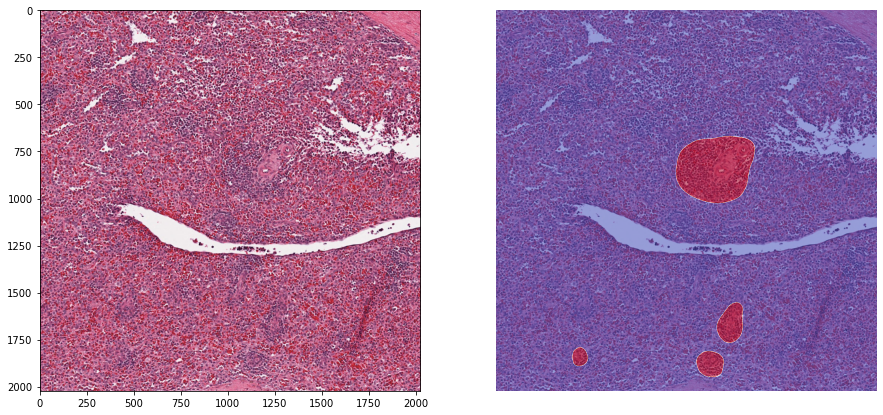

In [ ]:
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

img_1 = tiff.imread('../input/hubmap-organ-segmentation/test_images/10078.tiff')
mask_1 = rle2mask(df["rle"][0], (img_1.shape[1], img_1.shape[0]))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img_1)

plt.subplot(1,2,2)
plt.imshow(img_1)
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")
